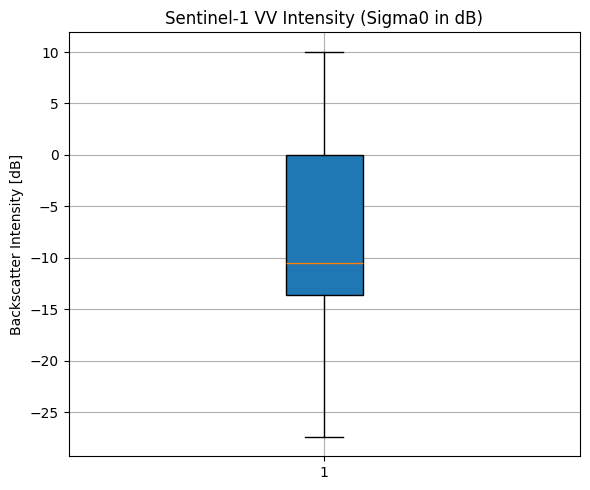

In [ ]:
# Box Plot and Histogram Sentinel-1 VV Intensity (Sigma0 in dB)
import rasterio
import numpy as np
import matplotlib.pyplot as plt

tiff_path = "/Users/manaspatil/Desktop/Acads/DAT/DAT/sigma0_VV_db.tif"

with rasterio.open(tiff_path) as src:
    sigma0_vv = src.read(1).flatten()

sigma0_vv = sigma0_vv[~np.isnan(sigma0_vv)]
sigma0_vv = sigma0_vv[sigma0_vv > -100]

plt.figure(figsize=(6, 5))
plt.boxplot(sigma0_vv, vert=True, patch_artist=True)
plt.title("Sentinel-1 VV Intensity (Sigma0 in dB)")
plt.ylabel("Backscatter Intensity [dB]")
plt.grid(True)
plt.tight_layout()
plt.savefig("sentinel1_vv_boxplot.png")
plt.show()


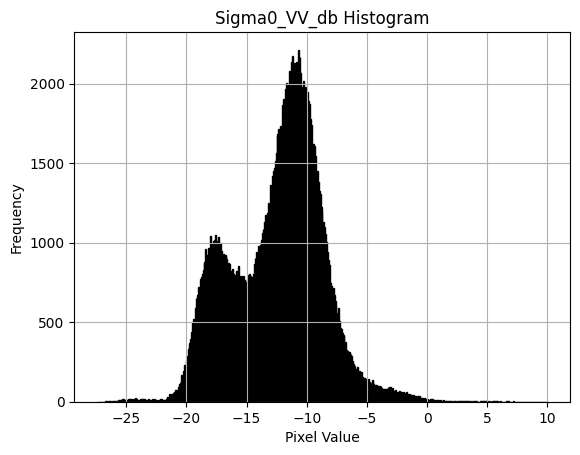

In [ ]:
valid_data = band3[(band3 != 0)]  

plt.hist(valid_data.flatten(), bins=512, range=(-27.4311, 10.0404), color='skyblue', edgecolor='black')
plt.title('Sigma0_VV_db Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

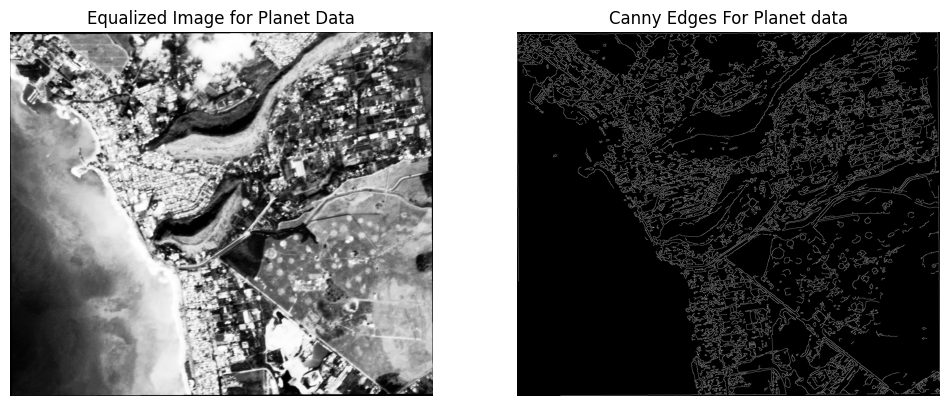

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Canny edge detection for both - planet and sentinal data 
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt
with rasterio.open("/Users/manaspatil/Desktop/Acads/DAT/DAT/band1.tif") as src:
    image = src.read(1)  
    

image_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
image_uint8 = image_norm.astype(np.uint8)

image_eq = cv2.equalizeHist(image_uint8)

blurred_image = cv2.GaussianBlur(image_eq, (5, 5), 0)

edges = cv2.Canny(blurred_image, 50, 150)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Equalized Image for Planet Data")
plt.imshow(image_eq, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Canny Edges For Planet data")
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()




with rasterio.open("/Users/manaspatil/Desktop/Acads/DAT/DAT/subset_0_of_S1A_IW_GRDH_1SDV_20241222T162412_20241222T162441_057107_07053F_848A.tif") as src:
    sigma0_vv_db = src.read(1)

sigma0_vv_db_norm = cv2.normalize(sigma0_vv_db, None, 0, 255, cv2.NORM_MINMAX)
sigma0_vv_db_uint8 = sigma0_vv_db_norm.astype(np.uint8)

sigma0_vv_db_eq = cv2.equalizeHist(sigma0_vv_db_uint8)

blurred_image = cv2.GaussianBlur(sigma0_vv_db_eq, (5, 5), 0)

edges = cv2.Canny(blurred_image, 50, 150)

plt.figure(figsize=(12, 6))


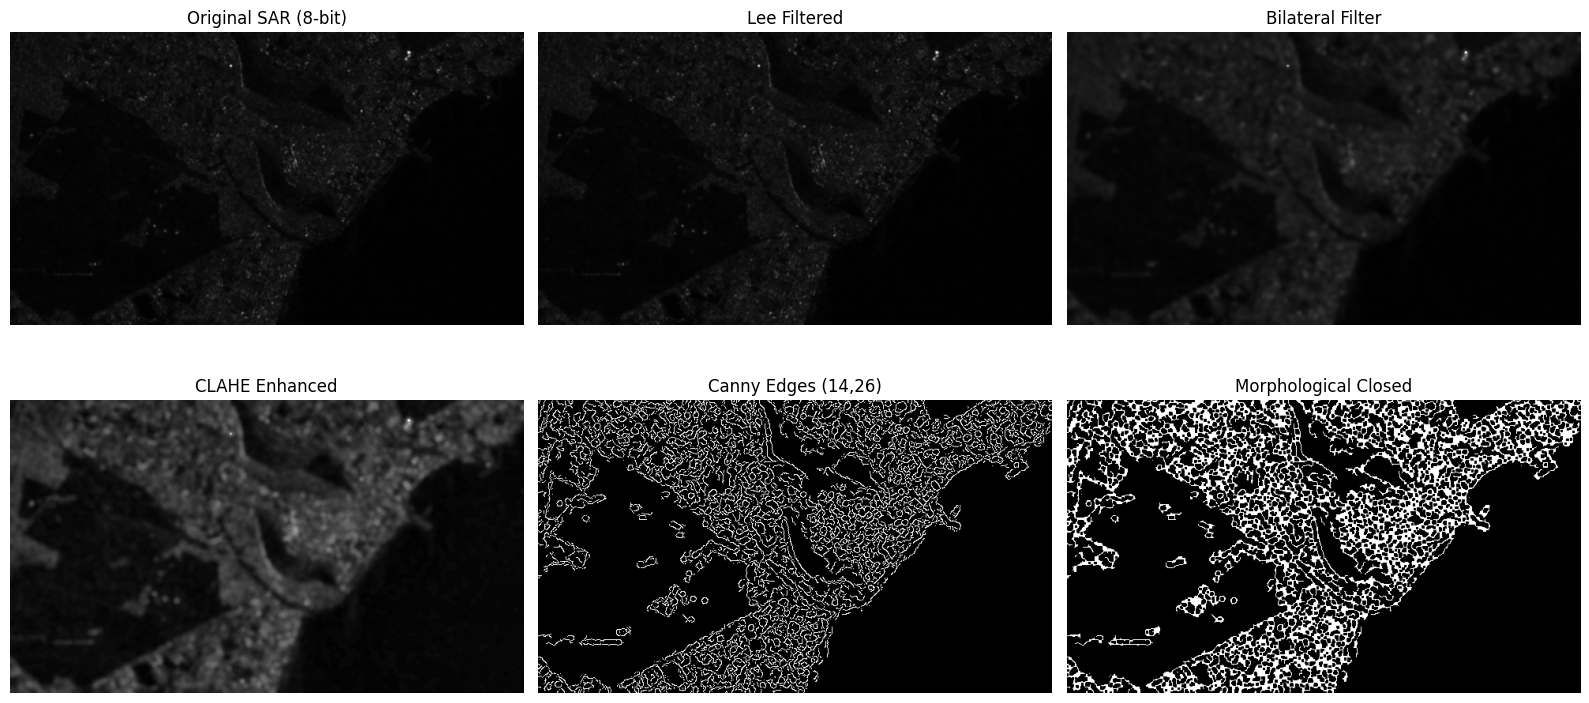

In [ ]:
# Improved SAR Edge Detection Pipeline
# This script applies speckle reduction, adaptive filtering, and enhanced edge detection
import rasterio
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = '/Users/manaspatil/Desktop/Acads/DAT/DAT/subset_0_of_S1A_IW_GRDH_1SDV_20241222T162412_20241222T162441_057107_07053F_848A.tif'
with rasterio.open(image_path) as src:
    sar = src.read(1).astype(np.float32)

def lee_filter(img, size=7, noise_variance=None):
    mean_kernel = cv2.blur(img, (size, size))
    sqmean_kernel = cv2.blur(img**2, (size, size))
    variance = sqmean_kernel - mean_kernel**2
    if noise_variance is None:
        noise_variance = np.mean(variance)
    weights = variance / (variance + noise_variance)
    return mean_kernel + weights * (img - mean_kernel)

filtered = lee_filter(sar, size=5)

norm = cv2.normalize(filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

bilat = cv2.bilateralFilter(norm, d=9, sigmaColor=75, sigmaSpace=75)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(bilat)

v = np.median(enhanced)
lower = int(max(0, 0.7 * v))
upper = int(min(255, 1.3 * v))
edged = cv2.Canny(enhanced, lower, upper, apertureSize=3)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Original SAR (8-bit)')
plt.imshow(norm, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Lee Filtered')
plt.imshow(cv2.normalize(filtered, None, 0,255,cv2.NORM_MINMAX).astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title('Bilateral Filter')
plt.imshow(bilat, cmap='gray')
plt.axis('off')

plt.subplot(2,3,4)
plt.title('CLAHE Enhanced')
plt.imshow(enhanced, cmap='gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.title(f'Canny Edges ({lower},{upper})')
plt.imshow(edged, cmap='gray')
plt.axis('off')

plt.subplot(2,3,6)
plt.title('Morphological Closed')
plt.imshow(closed, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


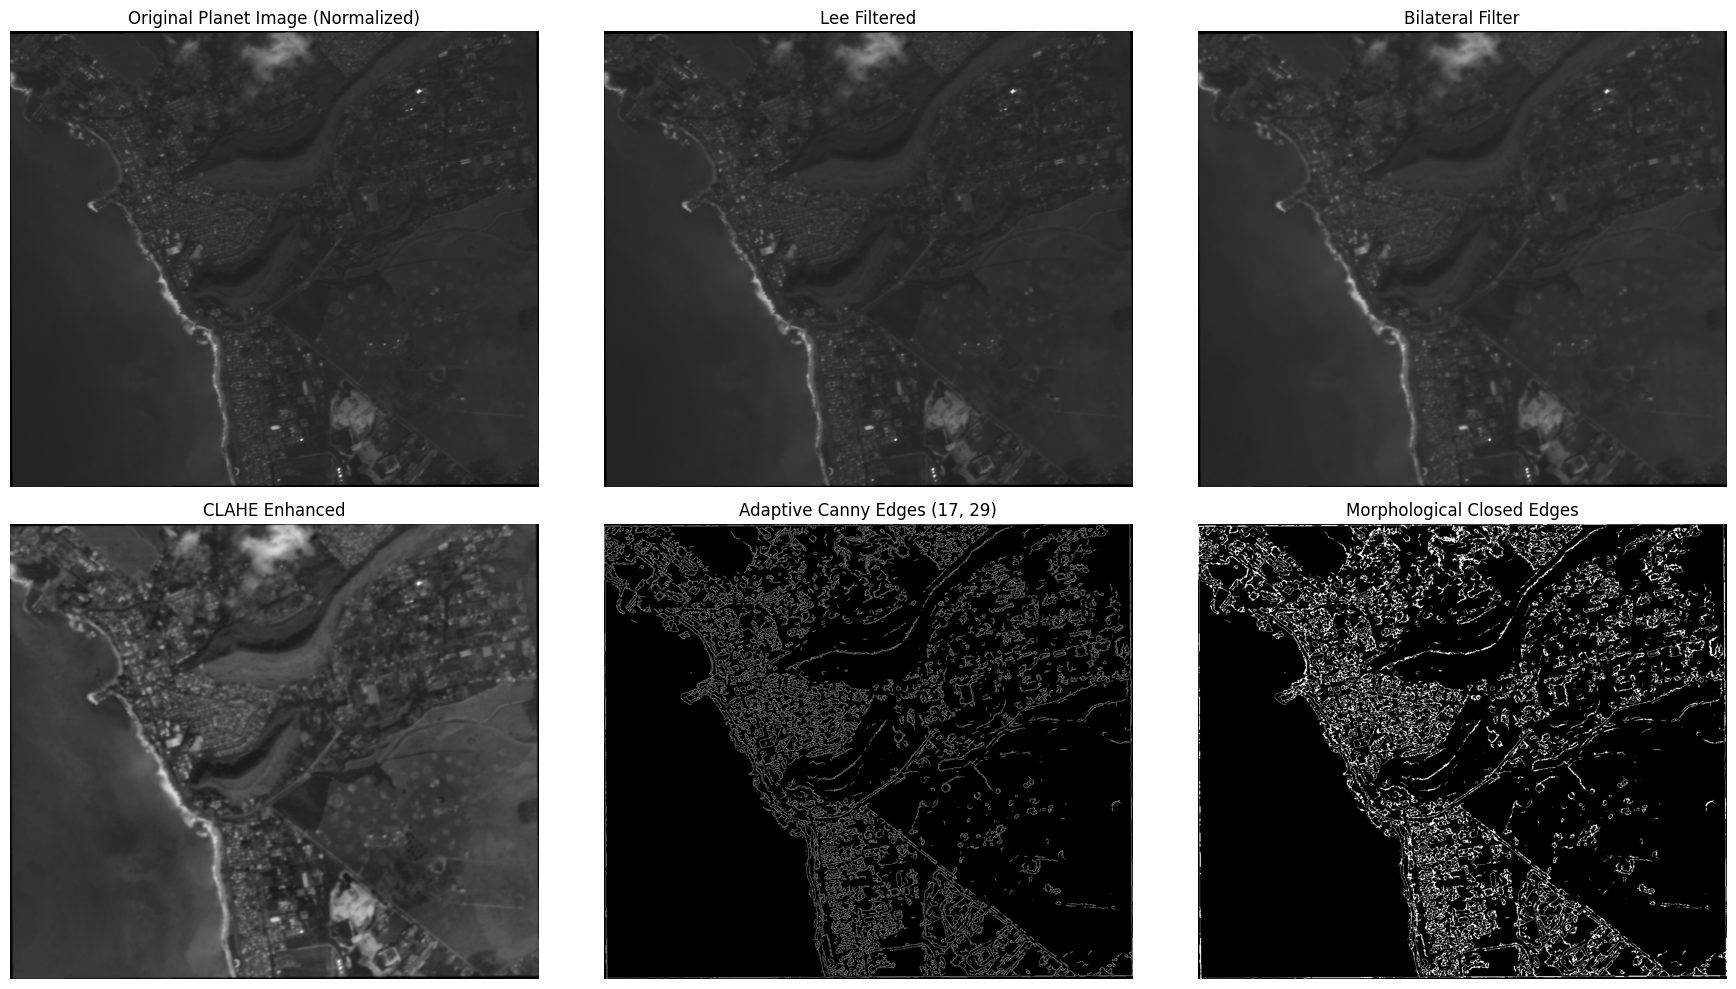

In [ ]:
# Do the same for Planet data
import rasterio
import cv2
import numpy as np
import matplotlib.pyplot as plt
with rasterio.open("/Users/manaspatil/Desktop/Acads/DAT/DAT/band1.tif") as src:
    planet_img = src.read(1).astype(np.float32)

def lee_filter(img, size=7, noise_variance=None):
    mean_kernel = cv2.blur(img, (size, size))
    sqmean_kernel = cv2.blur(img**2, (size, size))
    variance = sqmean_kernel - mean_kernel**2
    if noise_variance is None:
        noise_variance = np.mean(variance)
    weights = variance / (variance + noise_variance)
    return mean_kernel + weights * (img - mean_kernel)

lee_filtered = lee_filter(planet_img, size=5)

lee_norm = cv2.normalize(lee_filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

bilat = cv2.bilateralFilter(lee_norm, d=9, sigmaColor=75, sigmaSpace=75)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_enhanced = clahe.apply(bilat)

median_val = np.median(clahe_enhanced)
lower = int(max(0, 0.3 * median_val))
upper = int(min(255, 0.5 * median_val))

adaptive_edges = cv2.Canny(clahe_enhanced, lower, upper, apertureSize=3)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
morph_closed = cv2.morphologyEx(adaptive_edges, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
plt.title("Original Planet Image (Normalized)")
plt.imshow(cv2.normalize(planet_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title("Lee Filtered")
plt.imshow(lee_norm, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title("Bilateral Filter")
plt.imshow(bilat, cmap='gray')
plt.axis('off')

plt.subplot(2,3,4)
plt.title("CLAHE Enhanced")
plt.imshow(clahe_enhanced, cmap='gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.title(f"Adaptive Canny Edges ({lower}, {upper})")
plt.imshow(adaptive_edges, cmap='gray')
plt.axis('off')

plt.subplot(2,3,6)
plt.title("Morphological Closed Edges")
plt.imshow(morph_closed, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
